# Sprint-2. Новые данные

## Задача: Получить рабочую модель для прогона на протезе

###  Содержание <a class="anchor" id=0></a>

- [1. Загрузка библиотек, чтение данных, определение основных функций](#1)
- [2. Песочница с разными моделями](#2)
- [3. Песочница с разными пайплайнами](#3)
- [4. Эмуляция реал-тайм инференса](#4)
- [5. Итоги спринта](#5)


## 1. Загрузка библиотек, чтение данных, определение основных функций <a class="anchor" id=1></a>

[к содержанию](#0)

In [492]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
pd.options.display.float_format = '{:.6f}'.format #для отображения "обычных" float
%matplotlib widget

free_movements_1 = pd.read_csv('free_movements.csv', index_col=0)
free_movements_2 = pd.read_csv('free_movements_2.csv', index_col=0)

OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
# ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
GLOVE_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
INDEX = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5', 'MSE mean', 'RUN time'] # для удобства вывода отчетов
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(GLOVE_CH)+len(BUTTON_SYNC_TS_CH) == free_movements_1.shape[-1]

gestures_train_1 = pd.read_csv('gestures_train.csv', index_col=0)
gestures_test_1 = pd.read_csv('gestures_test.csv', index_col=0)
gestures_protocol_1 = pd.read_csv('gestures_protocol.csv')

gestures_train_2 = pd.read_csv('gestures_train_2.csv', index_col=0)
gestures_test_2 = pd.read_csv('gestures_test_2.csv', index_col=0)
gestures_protocol_2 = pd.read_csv('gestures_protocol_2.csv')

gestures_train_ext_1 = pd.merge(
    gestures_train_1,
    gestures_protocol_1,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

gestures_test_ext_1 = pd.merge(
    gestures_test_1,
    gestures_protocol_1,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

gestures_train_ext_2 = pd.merge(
    gestures_train_2,
    gestures_protocol_2,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

gestures_test_ext_2 = pd.merge(
    gestures_test_2,
    gestures_protocol_2,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

Забегая вперёд, при обработке данных и подборе модели, будем пользоваться функциями которые понадобятся в эмуляции `inferenc'а` в `real-time`.

In [33]:
import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error as mse


def MSE(y, y_pred):
    """_получение среднеквадратичной ошибки для каждого таргета_

    """
    ENC0 = mse(y[:,0], y_pred[:,0])
    ENC1 = mse(y[:,1], y_pred[:,1])
    ENC2 = mse(y[:,2], y_pred[:,2])
    ENC3 = mse(y[:,3], y_pred[:,3])
    ENC4 = mse(y[:,4], y_pred[:,4])
    ENC5 = mse(y[:,5], y_pred[:,5])
    MEAN = np.mean([ENC0, ENC1, ENC2, ENC3, ENC4, ENC5])
    return pd.Series([ENC0, ENC1, ENC2, ENC3, ENC4, ENC5, MEAN])

def preprocessing_static(x, prev):
    """_добавление изменения показаний датчиков за 1 шаг
        используется в качестве препроцессинга_
    """
    if prev is None:
        y = x
    else:
        y = x - prev 
    return np.append(x, y, axis=1)

def inference(x):
    """_получение предсказаний модели_

    """
    y = np.rint(model.predict(x))

    return y

def fast_post(array, step=10):
    
    return np.round(array / step, 0).astype(int) * step


def commands(x, prev):
    """_преобразование таргетов в команды
        используется в качестве финального "коэффициента подгона"_
        пока лучшего сглаживателя нет времено использую фильтр Хольта
    """
    if prev is None:
        y = x
    else:
        y = x*0.5 + prev*0.5
    return y

## 2. Песочница с разными моделями <a class="anchor" id=2></a>

[к содержанию](#0)

Прочитаем новые данные

In [34]:
X_1 = gestures_train_1[OMG_CH].values
X_test_1 = gestures_test_1[OMG_CH].values
y_1 = gestures_train_1[GLOVE_CH].values
y_test_1 = gestures_test_1[GLOVE_CH].values
print(X_1.shape, y_1.shape, X_test_1.shape, y_test_1.shape)

X_2 = gestures_train_2[OMG_CH].values
X_test_2 = gestures_test_2[OMG_CH].values
y_2 = gestures_train_2[GLOVE_CH].values
y_test_2 = gestures_test_2[GLOVE_CH].values
X_2.shape, y_2.shape, X_test_2.shape, y_test_2.shape


(28976, 50) (28976, 6) (7244, 50) (7244, 6)


((21320, 50), (21320, 6), (5330, 50), (5330, 6))

Посмотрим на таргеты, для разных пилотов

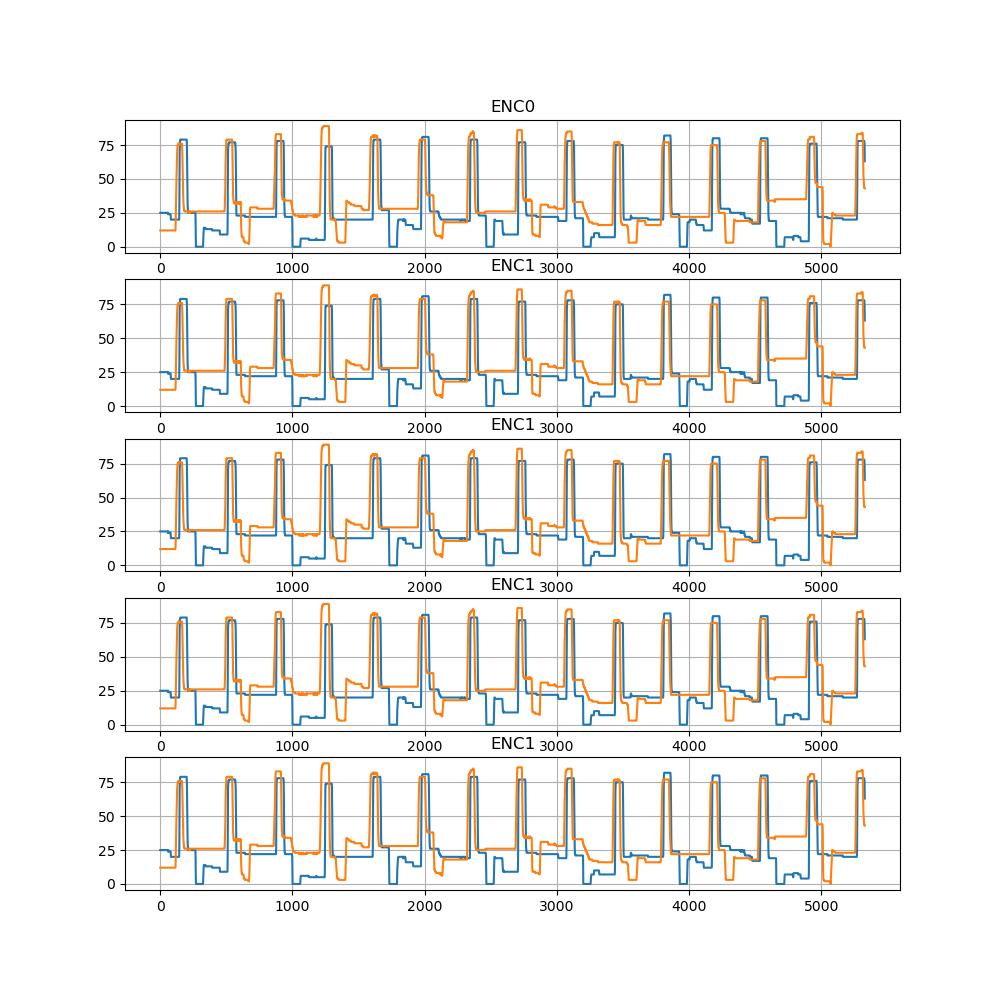

In [35]:
fig, ax = plt.subplots(5, 1, figsize=(10, 10))

ax[0].set_title('ENC0')
ax[0].plot(y_test_1[:,0][:5330])
ax[0].plot(y_test_2[:,0][:5330])
ax[0].grid()

ax[1].set_title('ENC1')
ax[1].plot(y_test_1[:,0][:5330])
ax[1].plot(y_test_2[:,0][:5330])
ax[1].grid()

ax[2].set_title('ENC1')
ax[2].plot(y_test_1[:,0][:5330])
ax[2].plot(y_test_2[:,0][:5330])
ax[2].grid()

ax[3].set_title('ENC1')
ax[3].plot(y_test_1[:,0][:5330])
ax[3].plot(y_test_2[:,0][:5330])
ax[3].grid()

ax[4].set_title('ENC1')
ax[4].plot(y_test_1[:,0][:5330])
ax[4].plot(y_test_2[:,0][:5330])
ax[4].grid()


Видим, что оба пилота выполняют одни и теже жесты.

Проверим работу датчиков на обоих пилотах

In [36]:
pilot_1_active_OMG = []
pilot_2_active_OMG = []
pilot_1_inactive_OMG = []
pilot_2_inactive_OMG = []

for i in np.arange(X_test_1.shape[1]):
    if (X_test_1[:,i] < 200).any():
        pilot_1_inactive_OMG.append(i)
    else:
        pilot_1_active_OMG.append(i)

for i in np.arange(X_test_2.shape[1]):
    if (X_test_2[:,i] < 200).any():
        pilot_2_inactive_OMG.append(i)
    else:
        pilot_2_active_OMG.append(i)

pilot_1_active_OMG = np.array(pilot_1_active_OMG)
pilot_2_active_OMG = np.array(pilot_2_active_OMG)
pilot_1_inactive_OMG = np.array(pilot_1_inactive_OMG)
pilot_2_inactive_OMG = np.array(pilot_2_inactive_OMG)

print('Активных датчиков:')
print(f'первый пилот: {pilot_1_active_OMG.shape[0]}\nвторой пилот: {pilot_2_active_OMG.shape[0]}')
print('Пассивных датчиков:')
print(f'первый пилот: {pilot_1_inactive_OMG.shape[0]}\nвторой пилот: {pilot_2_inactive_OMG.shape[0]}')
print(f'Номера этих датчиков совпадают: {(pilot_1_active_OMG == pilot_2_active_OMG).any()}')

Активных датчиков:
первый пилот: 16
второй пилот: 16
Пассивных датчиков:
первый пилот: 34
второй пилот: 34
Номера этих датчиков совпадают: True


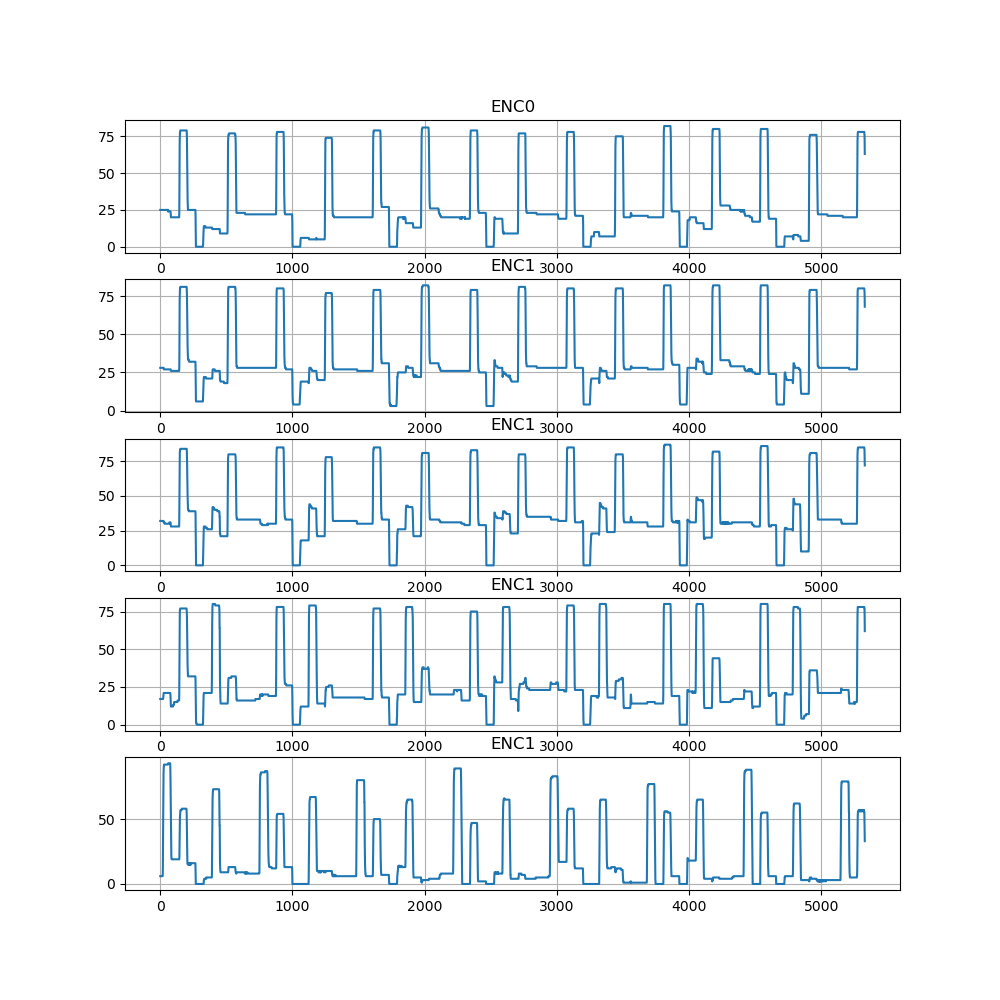

In [37]:
fig, ax = plt.subplots(5, 1, figsize=(10, 10))

ax[0].set_title('ENC0')
ax[0].plot(y_test_1[:,0][:5330])
ax[0].grid()

ax[1].set_title('ENC1')
ax[1].plot(y_test_1[:,1][:5330])
ax[1].grid()

ax[2].set_title('ENC1')
ax[2].plot(y_test_1[:,2][:5330])
ax[2].grid()

ax[3].set_title('ENC1')
ax[3].plot(y_test_1[:,3][:5330])
ax[3].grid()

ax[4].set_title('ENC1')
ax[4].plot(y_test_1[:,4][:5330])
ax[4].grid()

Text(740, 500, 'thumb up')

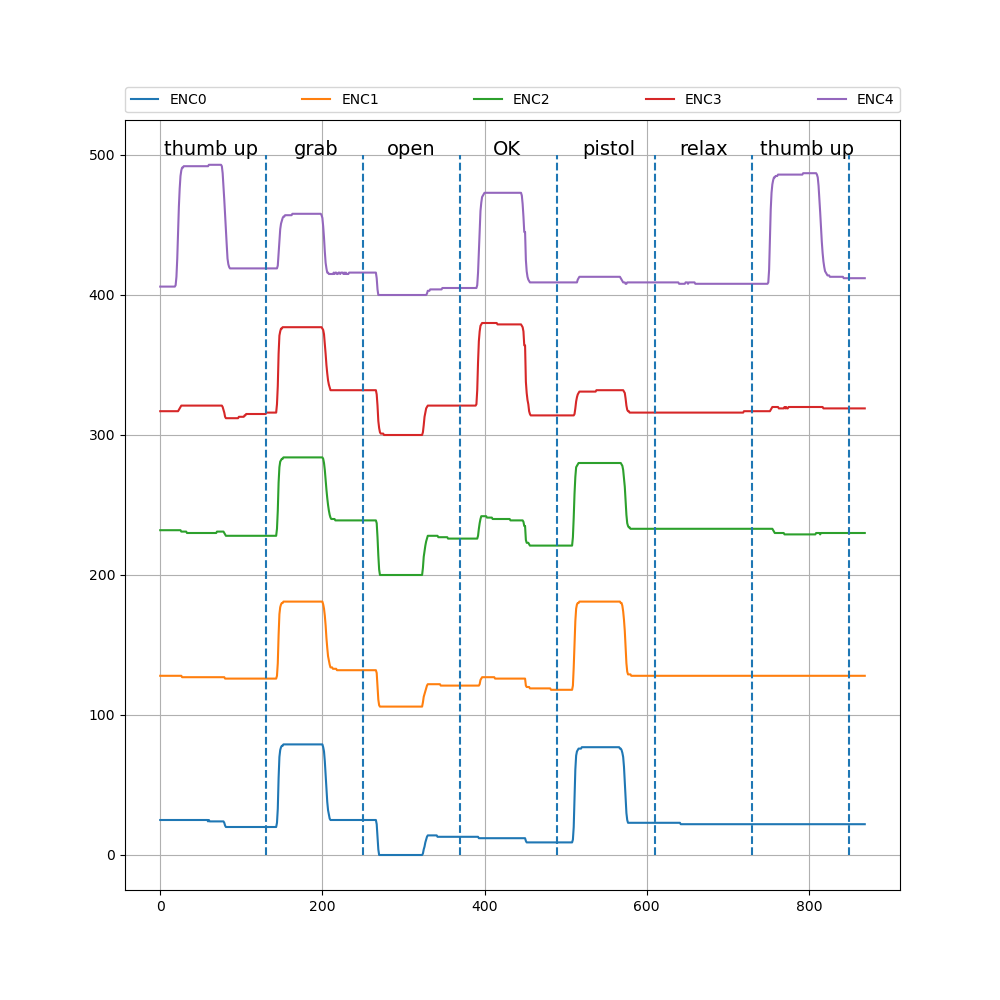

In [39]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(y_test_1[:,0][:870], label='ENC0')
ax.plot(y_test_1[:,1][:870] + 100, label='ENC1')
ax.plot(y_test_1[:,2][:870] + 200, label='ENC2')
ax.plot(y_test_1[:,3][:870] + 300, label='ENC3')
ax.plot(y_test_1[:,4][:870] + 400, label='ENC4')
ax.legend(bbox_to_anchor=(0, 1.01, 1, 1.01), loc='lower left',
                      ncols=5, mode="expand", borderaxespad=0.)
ax.grid()
ax.vlines(130, 0, 500, linestyles='--')
ax.vlines(250, 0, 500, linestyles='--')
ax.vlines(370, 0, 500, linestyles='--')
ax.vlines(490, 0, 500, linestyles='--')
ax.vlines(610, 0, 500, linestyles='--')
ax.vlines(730, 0, 500, linestyles='--')
ax.vlines(850, 0, 500, linestyles='--')

ax.text(5,500, 'thumb up', fontsize=14)
ax.text(165,500, 'grab', fontsize=14)
ax.text(280,500, 'open', fontsize=14)
ax.text(410,500, 'OK', fontsize=14)
ax.text(520,500, 'pistol', fontsize=14)
ax.text(640,500, 'relax', fontsize=14)
ax.text(740,500, 'thumb up', fontsize=14)

Text(740, 500, 'thumb up')

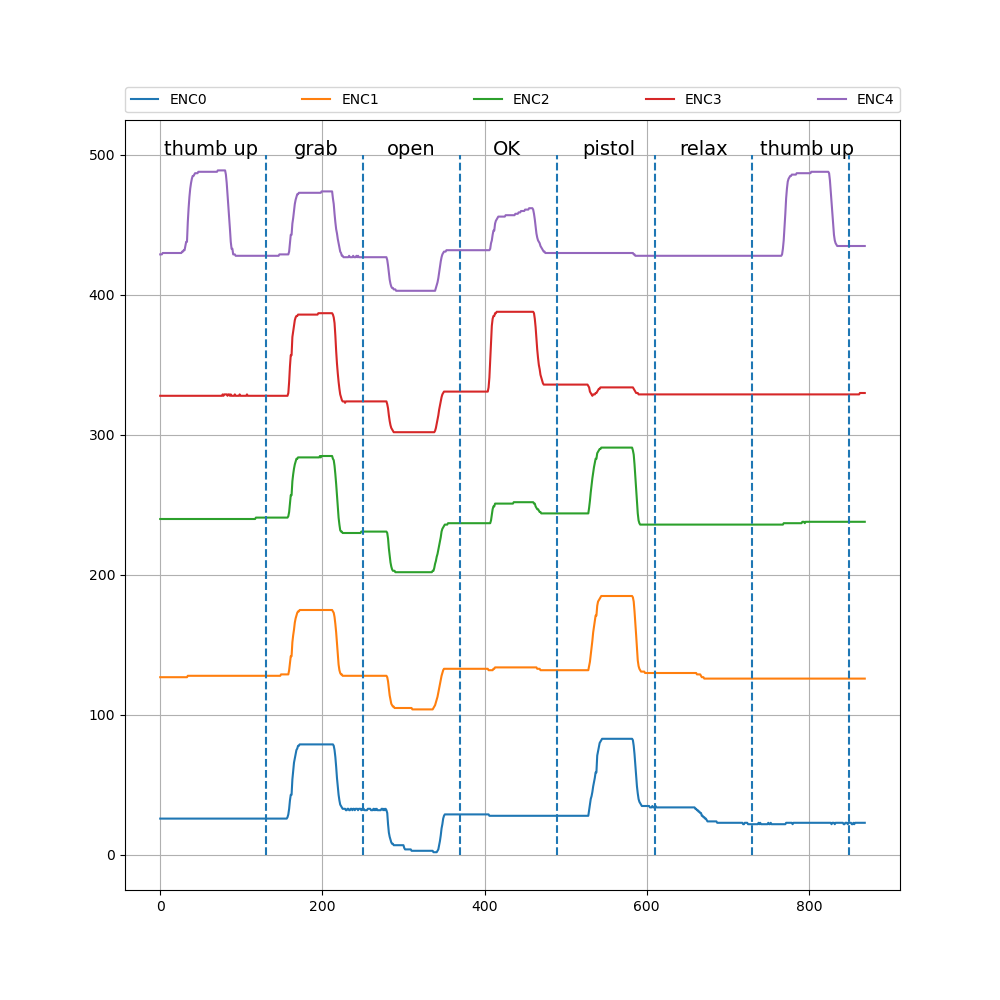

In [40]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(y_test_2[:,0][330:1200], label='ENC0')
ax.plot(y_test_2[:,1][330:1200] + 100, label='ENC1')
ax.plot(y_test_2[:,2][330:1200] + 200, label='ENC2')
ax.plot(y_test_2[:,3][330:1200] + 300, label='ENC3')
ax.plot(y_test_2[:,4][330:1200] + 400, label='ENC4')
ax.legend(bbox_to_anchor=(0, 1.01, 1, 1.01), loc='lower left',
                      ncols=5, mode="expand", borderaxespad=0.)
ax.grid()
ax.vlines(130, 0, 500, linestyles='--')
ax.vlines(250, 0, 500, linestyles='--')
ax.vlines(370, 0, 500, linestyles='--')
ax.vlines(490, 0, 500, linestyles='--')
ax.vlines(610, 0, 500, linestyles='--')
ax.vlines(730, 0, 500, linestyles='--')
ax.vlines(850, 0, 500, linestyles='--')

ax.text(5,500, 'thumb up', fontsize=14)
ax.text(165,500, 'grab', fontsize=14)
ax.text(280,500, 'open', fontsize=14)
ax.text(410,500, 'OK', fontsize=14)
ax.text(520,500, 'pistol', fontsize=14)
ax.text(640,500, 'relax', fontsize=14)
ax.text(740,500, 'thumb up', fontsize=14)

In [41]:
def get_diff(array, min=-400, max=400):
    new_array = np.sum(array, axis=1) - np.sum(np.vstack([array[1:], array[:1]]), axis=1)
    new_array[(new_array < 0) & (new_array > min)] = 0
    new_array[(new_array > 0) & (new_array < max)] = 0
    return new_array

In [42]:
def classer(array, min=0.1, max=0.6):
    new_array = np.sum(array, axis=1)
    new_array[new_array <= np.quantile(new_array, 0.1)] = 0
    new_array[(new_array > np.quantile(new_array, 0.1)) & (new_array < np.quantile(new_array, 0.6))] = 1
    new_array[(new_array != 0) & (new_array != 1)] = 2
    return new_array

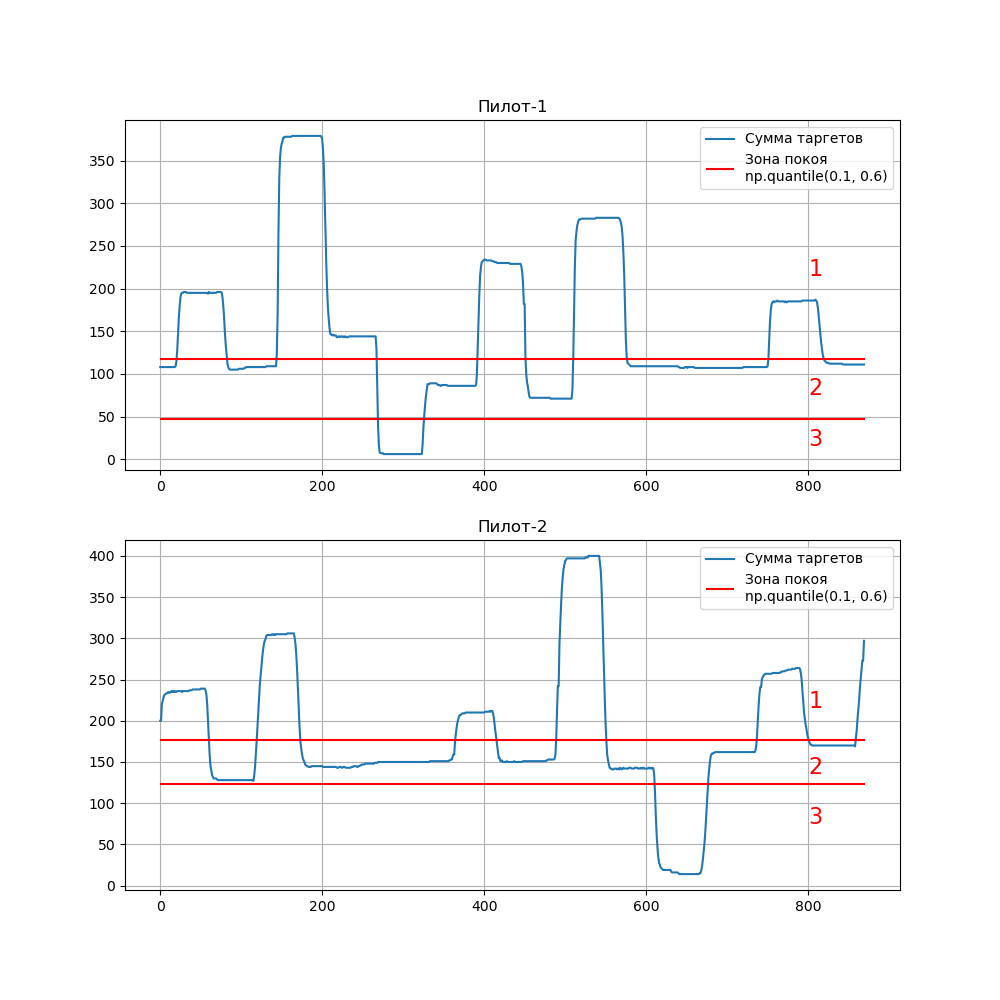

In [43]:
fig, ax = plt.subplots(2,1, figsize=(10, 10))


ax[0].plot(np.sum(y_test_1[:870], axis=1), label='Сумма таргетов')
ax[0].hlines(np.quantile(np.sum(y_test_1, axis=1), 0.1), 0, 870, color='r', label='Зона покоя\nnp.quantile(0.1, 0.6)')
ax[0].hlines(np.quantile(np.sum(y_test_1, axis=1), 0.6), 0, 870, color='r')
ax[0].grid()
ax[0].set_title('Пилот-1')
ax[0].text(800, 215, '1', color='r', fontsize=16)
ax[0].text(800, 75, '2', color='r', fontsize=16)
ax[0].text(800, 15, '3', color='r', fontsize=16)
ax[0].legend()

ax[1].plot(np.sum(y_test_2[:870], axis=1), label='Сумма таргетов')
ax[1].hlines(np.quantile(np.sum(y_test_2, axis=1), 0.1), 0, 870, color='r', label='Зона покоя\nnp.quantile(0.1, 0.6)')
ax[1].hlines(np.quantile(np.sum(y_test_2, axis=1), 0.6), 0, 870, color='r')
ax[1].grid()
ax[1].set_title('Пилот-2')
ax[1].text(800, 215, '1', color='r', fontsize=16)
ax[1].text(800, 135, '2', color='r', fontsize=16)
ax[1].text(800, 75, '3', color='r', fontsize=16)
ax[1].legend()

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error as mse

y_1_class = classer(y_1)
y_test_1_class = classer(y_test_1)

LogR = LogisticRegression().fit(X_1, y_1_class)

y_1_pred = LogR.predict(X_1)
y_test_1_pred = LogR.predict(X_test_1)

print(f'train: {mse(y_1_class, y_1_pred)}')
print(f'test: {mse(y_test_1_class, y_test_1_pred)}')

train: 0.230190502484815
test: 0.1906405300938708


In [46]:
y_2_class = classer(y_2)
y_test_2_class = classer(y_test_2)

LogR = LogisticRegression().fit(X_2, y_2_class)

y_2_pred = LogR.predict(X_2)
y_test_2_pred = LogR.predict(X_test_2)

print(f'train: {mse(y_2_class, y_2_pred)}')
print(f'test: {mse(y_test_2_class, y_test_2_pred)}')

train: 0.12204502814258912
test: 0.09080675422138837


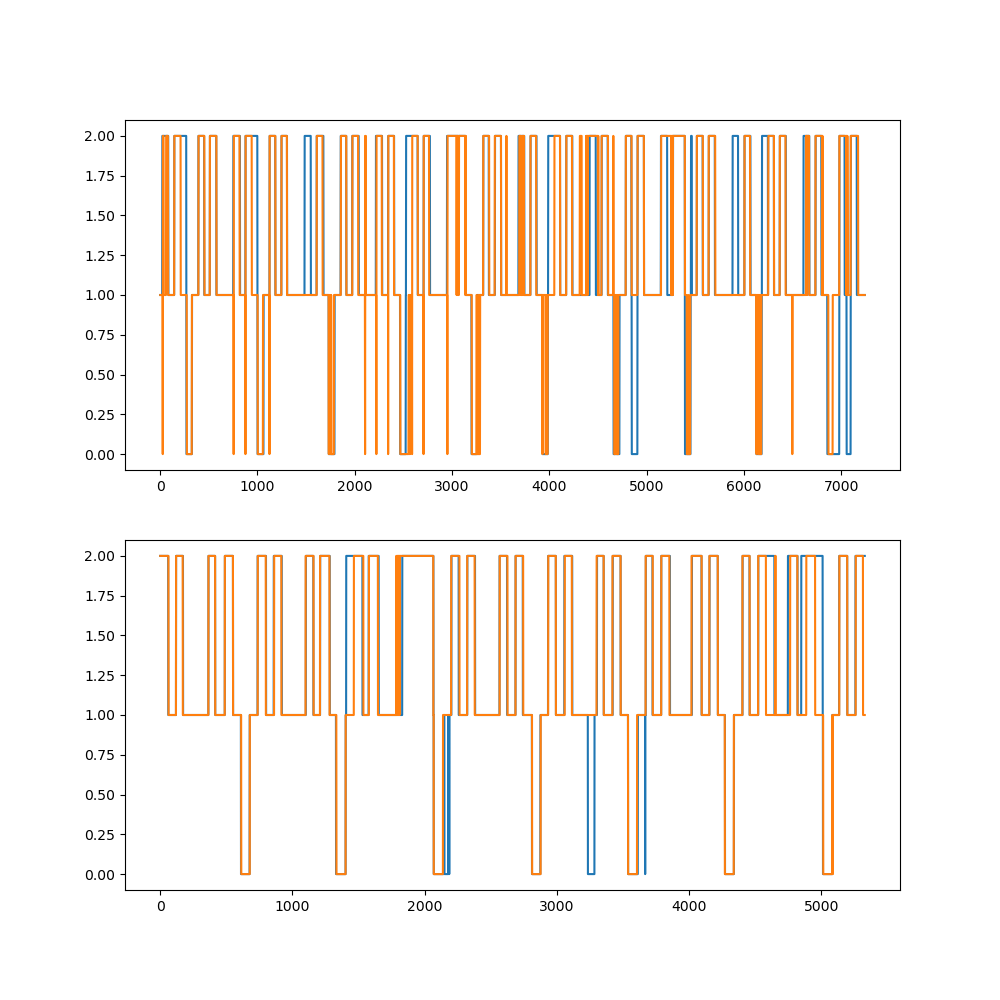

In [49]:
fig, ax = plt.subplots(2,1, figsize=(10, 10))

ax[0].plot(y_test_1_class)
ax[0].plot(y_test_1_pred)

ax[1].plot(y_test_2_class)
ax[1].plot(y_test_2_pred)

## Пока отложим классификатор, пробежимся по базовым моделям

и послотрим насколько плохо будет, если мы обучим модель на данных первого пилота а предсказания снимем со второго

In [50]:
# время выполнения ~ 11s
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LassoLars

lr_1 = LinearRegression().fit(X_1, y_1)

start_time = time.time()

y_pred_1 = lr_1.predict(X_1)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred_1 = lr_1.predict(X_test_1)

LR_1 = pd.DataFrame({'INDEX':INDEX, 'LR_1':MSE(y_test_1, y_test_pred_1).append(run_time)}).set_index('INDEX')


start_time = time.time()

y_pred_2 = lr_1.predict(X_2)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred_2 = lr_1.predict(X_test_2)

LR_2 = pd.DataFrame({'INDEX':INDEX, 'LR_2':MSE(y_test_2, y_test_pred_2).append(run_time)}).set_index('INDEX')



en_1 = ElasticNet().fit(X_1, y_1)

start_time = time.time()

y_pred_1 = en_1.predict(X_1)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred_1 = en_1.predict(X_test_1)

EN_1 = pd.DataFrame({'INDEX':INDEX, 'EN_1':MSE(y_test_1, y_test_pred_1).append(run_time)}).set_index('INDEX')


start_time = time.time()

y_pred_2 = en_1.predict(X_2)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred_2 = en_1.predict(X_test_2)

EN_2 = pd.DataFrame({'INDEX':INDEX, 'EN_2':MSE(y_test_2, y_test_pred_2).append(run_time)}).set_index('INDEX')


ll_1 = LassoLars().fit(X_1, y_1)

start_time = time.time()

y_pred_1 = ll_1.predict(X_1)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred_1 = ll_1.predict(X_test_1)

LL_1 = pd.DataFrame({'INDEX':INDEX, 'LL_1':MSE(y_test_1, y_test_pred_1).append(run_time)}).set_index('INDEX')


start_time = time.time()

y_pred_2 = ll_1.predict(X_2)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred_2 = ll_1.predict(X_test_2)

LL_2 = pd.DataFrame({'INDEX':INDEX, 'LL_2':MSE(y_test_2, y_test_pred_2).append(run_time)}).set_index('INDEX')



print('Итог по линейкам "из коробки":')
Linear_df = pd.concat([LR_1, LR_2, EN_1, EN_2, LL_1, LL_2], axis=1)
Linear_df

Итог по линейкам "из коробки":


,LR_1,LR_2,EN_1,EN_2,LL_1,LL_2
INDEX,,,,,,
ENC0,99.183001,5955.384382,99.836684,6925.476454,100.063839,6688.675361
ENC1,64.785053,1732.201165,65.548939,2354.041557,66.358558,2935.454807
ENC2,74.754737,1688.439179,75.954040,2219.200982,76.698188,2588.430062
ENC3,76.042074,22675.090640,74.701653,20385.668439,74.323777,19163.703607
ENC4,299.402720,51042.680701,299.246571,42943.799133,299.333712,39114.311837
ENC5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MSE mean,102.361264,13848.966011,102.547981,12471.364428,102.796346,11748.429279
RUN time,0.014950,0.011969,0.013962,0.009974,0.013966,0.010975


In [51]:
# время выполнения ~ 26s

pd.options.display.float_format = '{:.6f}'.format #для отображения "обычных" float

import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb

xgbr = xgb.XGBRegressor(objective='reg:squarederror', eval_metric=mse)
xgbr.fit(X_1, y_1)

start_time = time.time()

y_pred = xgbr.predict(X_1)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred_1 = xgbr.predict(X_test_1)

XGB_1 = pd.DataFrame({'INDEX':INDEX, 'XGBR_1':MSE(y_test_1, y_test_pred_1).append(run_time)}).set_index('INDEX')

start_time = time.time()

y_pred = xgbr.predict(X_2)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred_2 = xgbr.predict(X_test_2)

XGB_2 = pd.DataFrame({'INDEX':INDEX, 'XGBR_2':MSE(y_test_2, y_test_pred_2).append(run_time)}).set_index('INDEX')


lgbr = MultiOutputRegressor(lgb.LGBMRegressor())
lgbr.fit(X_1, y_1)

start_time = time.time()

y_pred = lgbr.predict(X_1)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred = lgbr.predict(X_test_1)

LGB_1 = pd.DataFrame({'INDEX':INDEX, 'LGBMR_1':MSE(y_test_1, y_test_pred_1).append(run_time)}).set_index('INDEX')

start_time = time.time()

y_pred = lgbr.predict(X_2)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred = lgbr.predict(X_test_2)

LGB_2 = pd.DataFrame({'INDEX':INDEX, 'LGBMR_2':MSE(y_test_2, y_test_pred_2).append(run_time)}).set_index('INDEX')

print('Итог по бустерам "из коробки":')
Booster_df = pd.concat([XGB_1, XGB_2, LGB_1, LGB_2], axis=1)
Booster_df

Итог по бустерам "из коробки":


,XGBR_1,XGBR_2,LGBMR_1,LGBMR_2
INDEX,,,,
ENC0,102.967986,398.461780,102.967986,398.461780
ENC1,55.984799,432.468750,55.984799,432.468750
ENC2,89.317313,982.278782,89.317313,982.278782
ENC3,77.367085,3595.468024,77.367085,3595.468024
ENC4,314.691441,1589.965068,314.691441,1589.965068
ENC5,0.000000,0.000000,0.000000,0.000000
MSE mean,106.721438,1166.440401,106.721438,1166.440401
RUN time,0.054849,0.041888,0.324131,0.206446


И мой любимый стек

In [17]:
# время выполнения ~ 6s
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoLars
from sklearn.ensemble import VotingRegressor

estimators = [
    ('dt', DecisionTreeRegressor()),
    ('ll', LassoLars())
]
model_vr = MultiOutputRegressor(VotingRegressor(estimators=estimators))

model_vr.fit(X_1, y_1)

start_time = time.time()

y_pred = model_vr.predict(X_1)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred_1 = model_vr.predict(X_test_1)

VR_1 = pd.DataFrame({'INDEX':INDEX, 'VR_1':MSE(y_test_1, y_test_pred_1).append(run_time)}).set_index('INDEX')

start_time = time.time()

y_pred = model_vr.predict(X_2)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred_2 = model_vr.predict(X_test_2)

VR_2 = pd.DataFrame({'INDEX':INDEX, 'VR_2':MSE(y_test_2, y_test_pred_2).append(run_time)}).set_index('INDEX')

In [52]:
print('Итог по базовым моделям:')
Models_df = pd.concat([Linear_df, Booster_df, VR_1, VR_2], axis=1)
Models_df

Итог по базовым моделям:


,LR_1,LR_2,EN_1,EN_2,LL_1,LL_2,XGBR_1,XGBR_2,LGBMR_1,LGBMR_2,VR_1,VR_2
INDEX,,,,,,,,,,,,
ENC0,99.183001,5955.384382,99.836684,6925.476454,100.063839,6688.675361,102.967986,398.461780,102.967986,398.461780,104.478680,1685.355965
ENC1,64.785053,1732.201165,65.548939,2354.041557,66.358558,2935.454807,55.984799,432.468750,55.984799,432.468750,67.645934,1051.624344
ENC2,74.754737,1688.439179,75.954040,2219.200982,76.698188,2588.430062,89.317313,982.278782,89.317313,982.278782,76.940479,570.153628
ENC3,76.042074,22675.090640,74.701653,20385.668439,74.323777,19163.703607,77.367085,3595.468024,77.367085,3595.468024,73.532406,7847.294821
ENC4,299.402720,51042.680701,299.246571,42943.799133,299.333712,39114.311837,314.691441,1589.965068,314.691441,1589.965068,277.524336,12487.840955
ENC5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MSE mean,102.361264,13848.966011,102.547981,12471.364428,102.796346,11748.429279,106.721438,1166.440401,106.721438,1166.440401,100.020306,3940.378286
RUN time,0.014950,0.011969,0.013962,0.009974,0.013966,0.010975,0.054849,0.041888,0.324131,0.206446,0.099733,0.066821


In [309]:
Models_df[['LR_1','XGBR_1','VR_1']]

,LR_1,XGBR_1,VR_1
INDEX,,,
ENC0,99.183001,102.967986,104.478680
ENC1,64.785053,55.984799,67.645934
ENC2,74.754737,89.317313,76.940479
ENC3,76.042074,77.367085,73.532406
ENC4,299.402720,314.691441,277.524336
ENC5,0.000000,0.000000,0.000000
MSE mean,102.361264,106.721438,100.020306
RUN time,0.014950,0.054849,0.099733


## Определим тройку финалистов

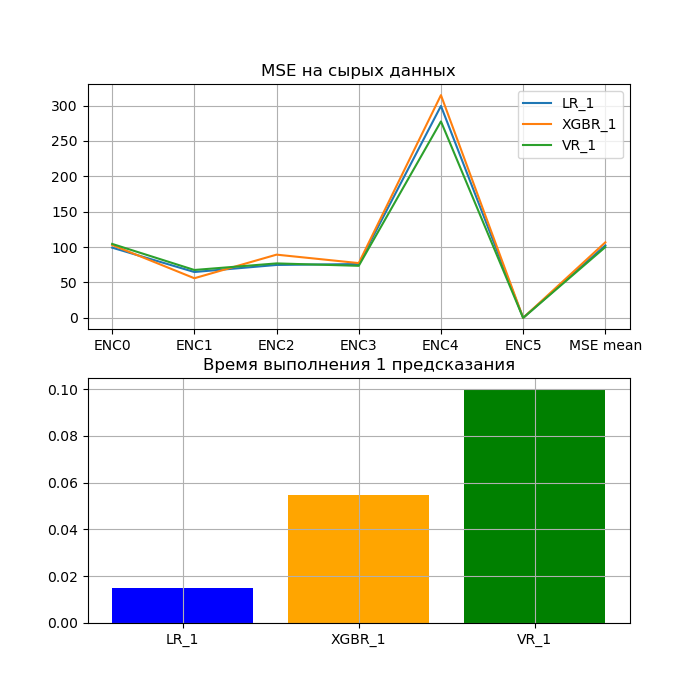

In [55]:
fig, ax = plt.subplots(2, 1, figsize=(7, 7))

ax[0].set_title('MSE на сырых данных')
ax[0].plot(Models_df[['LR_1','XGBR_1','VR_1']].drop('RUN time', axis=0),
           label=['LR_1','XGBR_1','VR_1'])
ax[0].legend()
ax[0].grid()
ax[1].set_title('Время выполнения 1 предсказания')
ax[1].bar(x=Models_df[['LR_1','XGBR_1','VR_1']].iloc[-1].index,
          height=Models_df[['LR_1','XGBR_1','VR_1']].iloc[-1].values,
          color = ['blue', 'orange', 'green'])
ax[1].grid()

***
## Соберём данный обоих пилотов в один сет и обучим модельки

In [353]:
X = np.vstack([X_1, X_2])
y = np.vstack([y_1, y_2])
X.shape, y.shape

((50296, 50), (50296, 6))

In [373]:
# ~0.5s
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(X, y)

pilot_1 = MSE(y_test_1, lr.predict(X_test_1))
pilot_2 = MSE(y_test_2, lr.predict(X_test_2))

lr_full_data = pd.DataFrame({'INDEX':['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5', 'MSE mean'],'lr_pilot_1':pilot_1, 'lr_pilot_2':pilot_2}).set_index('INDEX')
lr_full_data

,lr_pilot_1,lr_pilot_2
INDEX,,
ENC0,144.452417,149.452798
ENC1,101.116083,117.938012
ENC2,117.696557,108.818361
ENC3,107.812676,180.603738
ENC4,413.214784,105.420510
ENC5,0.000000,0.000000
MSE mean,147.382086,110.372236


In [378]:
# время выполнения ~ 10s
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoLars
from sklearn.ensemble import VotingRegressor

estimators = [
    ('dt', DecisionTreeRegressor()),
    ('ll', LassoLars())
]
model_vr = MultiOutputRegressor(VotingRegressor(estimators=estimators)).fit(X, y)

pilot_1 = MSE(y_test_1, model_vr.predict(X_test_1))
pilot_2 = MSE(y_test_2, model_vr.predict(X_test_2))

vr_full_data = pd.DataFrame({'INDEX':['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5', 'MSE mean'],'vr_pilot_1':pilot_1, 'vr_pilot_2':pilot_2}).set_index('INDEX')
vr_full_data

,vr_pilot_1,vr_pilot_2
INDEX,,
ENC0,113.816847,121.718248
ENC1,88.916244,75.950805
ENC2,95.323087,71.162798
ENC3,88.610328,111.677421
ENC4,360.755597,76.971429
ENC5,0.000000,0.000000
MSE mean,124.570351,76.246783


In [379]:
# время выполнения ~ 17s
import xgboost as xgb

xgbr = xgb.XGBRegressor(objective='reg:squarederror', eval_metric=mse).fit(X,y)

pilot_1 = MSE(y_test_1, xgbr.predict(X_test_1))
pilot_2 = MSE(y_test_2, xgbr.predict(X_test_2))

xgbr_full_data = pd.DataFrame({'INDEX':['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5', 'MSE mean'], 'xgbr_pilot_1':pilot_1, 'xgbr_pilot_2':pilot_2}).set_index('INDEX')
xgbr_full_data

,xgbr_pilot_1,xgbr_pilot_2
INDEX,,
ENC0,84.602160,116.967486
ENC1,65.823292,86.964475
ENC2,73.884940,53.595378
ENC3,65.771424,68.312201
ENC4,313.794287,70.899384
ENC5,0.000000,0.000000
MSE mean,100.646017,66.123154


In [382]:
Models_full_df = pd.concat([lr_full_data, vr_full_data, xgbr_full_data], axis=1)
Models_full_df

,lr_pilot_1,lr_pilot_2,vr_pilot_1,vr_pilot_2,xgbr_pilot_1,xgbr_pilot_2
INDEX,,,,,,
ENC0,144.452417,149.452798,113.816847,121.718248,84.602160,116.967486
ENC1,101.116083,117.938012,88.916244,75.950805,65.823292,86.964475
ENC2,117.696557,108.818361,95.323087,71.162798,73.884940,53.595378
ENC3,107.812676,180.603738,88.610328,111.677421,65.771424,68.312201
ENC4,413.214784,105.420510,360.755597,76.971429,313.794287,70.899384
ENC5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MSE mean,147.382086,110.372236,124.570351,76.246783,100.646017,66.123154


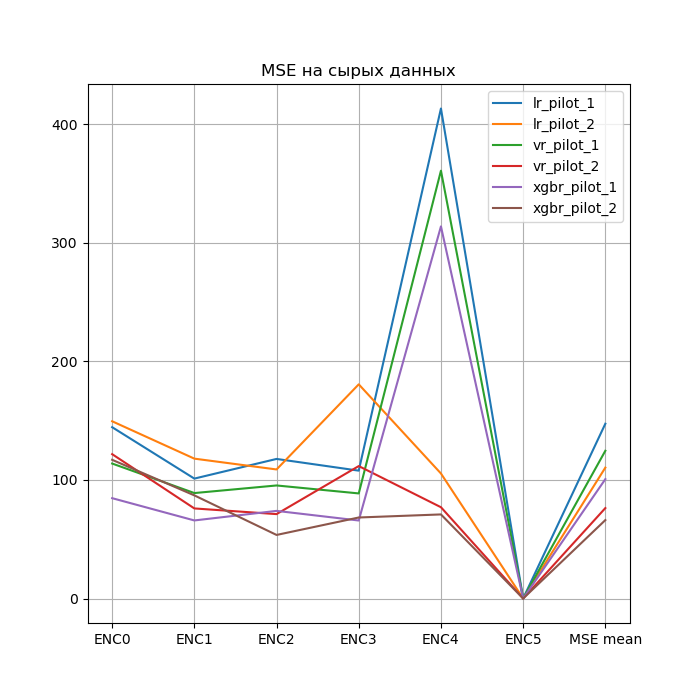

In [383]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.set_title('MSE на сырых данных')
ax.plot(Models_full_df, label=Models_full_df.columns)
ax.legend()
ax.grid()

Плохенько конечно, но ничего. Теперь проверим разбросы коэффициентов линеек.

Обучим 100 линеек по перемешанным данным и посмотрим как поведут себя коэффициенты прогрессий

In [483]:
Xy = np.hstack([X, y])
Xy[:,[50,51,52,53,54,55]]

array([[37, 50, 54, 44,  5,  0],
       [37, 50, 54, 44,  5,  0],
       [37, 50, 54, 44,  5,  0],
       ...,
       [12, 18, 29, 44, 30,  0],
       [12, 19, 34, 61, 33,  0],
       [12, 20, 38, 76, 37,  0]], dtype=int64)

In [670]:
def lr_by_hand(Xy, num=10):
    array = Xy.copy()
    lr_weight = []
    X_list = []
    y_list = []
    
    for i in np.arange(num):
        np.random.shuffle(array)
        X = array[:,np.arange(50)]
        y = array[:,[50,51,52,53,54,55]]
        weight = np.linalg.inv(X.T @ X) @ X.T @ y
        X_list.append(X)
        y_list.append(y)
        lr_weight.append(weight)
        
    lr_weight = np.array(lr_weight)
    X_list = np.array(X_list)
    y_list = np.array(y_list)
              
    return lr_weight, X_list, y_list
                     

In [671]:
lr_weight, X_list, y_list = lr_by_hand(Xy)

In [682]:
lr_weight.shape[0]


10

In [680]:
y_test_1.shape

(7244, 6)

In [679]:
(X_test_1 @ lr_weight[0]).shape

(7244, 6)

In [688]:
lst = []
for i in np.arange(lr_weight.shape[0]):
    lst.append([MSE(y_test_1, (X_test_1 @ lr_weight[i]))])

In [689]:
lst

[[0   139.867282
  1    99.848250
  2   117.419040
  3   111.177818
  4   415.173719
  5     0.000000
  6   147.247685
  dtype: float64],
 [0   139.867282
  1    99.848250
  2   117.419040
  3   111.177818
  4   415.173719
  5     0.000000
  6   147.247685
  dtype: float64],
 [0   139.867282
  1    99.848250
  2   117.419040
  3   111.177818
  4   415.173719
  5     0.000000
  6   147.247685
  dtype: float64],
 [0   139.867282
  1    99.848250
  2   117.419040
  3   111.177818
  4   415.173719
  5     0.000000
  6   147.247685
  dtype: float64],
 [0   139.867282
  1    99.848250
  2   117.419040
  3   111.177818
  4   415.173719
  5     0.000000
  6   147.247685
  dtype: float64],
 [0   139.867282
  1    99.848250
  2   117.419040
  3   111.177818
  4   415.173719
  5     0.000000
  6   147.247685
  dtype: float64],
 [0   139.867282
  1    99.848250
  2   117.419040
  3   111.177818
  4   415.173719
  5     0.000000
  6   147.247685
  dtype: float64],
 [0   139.867282
  1    99.848250


In [605]:
X_lst[0] @ (np.linalg.inv(X_lst[0].T @ X_lst[0]) @ X_lst[0].T @ y_lst[0])

array([[22.47781784, 27.21169108, 31.78150688, 21.93948605,  2.87676293,
         0.        ],
       [23.2840399 , 30.48752314, 40.96149561, 64.6767122 , 61.36544454,
         0.        ],
       [61.88870818, 68.32367336, 77.53109821, 39.2788478 , 32.25477265,
         0.        ],
       ...,
       [18.66226596, 27.40231087, 37.27491649, 31.61775635, 35.74780671,
         0.        ],
       [25.94771678, 38.35936945, 50.66668736, 67.50671661, 62.15481371,
         0.        ],
       [11.17601435, 17.91968938, 24.63462032, 25.8613557 , 26.37520339,
         0.        ]])

In [606]:
y_lst[0]

array([[26, 30, 37, 23,  3,  0],
       [20, 29, 46, 81, 73,  0],
       [86, 86, 92, 32, 36,  0],
       ...,
       [22, 32, 43, 36, 32,  0],
       [11, 27, 41, 80, 73,  0],
       [21, 26, 35, 25,  7,  0]], dtype=int64)

In [561]:
MSE(y_1, np.dot(X_1,w))

0   119.433428
1    99.874602
2   111.438733
3   140.202786
4   457.136472
5     0.000000
6   154.681004
dtype: float64

In [497]:
MSE(y, lr.predict(X))

0   118.576105
1    94.994333
2    98.415879
3   151.264201
4   314.816834
5     0.000000
6   129.677892
dtype: float64

In [588]:
np.array(lr_coef).shape

(10, 6, 50)

In [581]:
w[0]

array([ 5.30925623e-05, -4.40581711e-03, -4.70830919e-03,  3.40652022e-02,
       -1.17625903e-02,  0.00000000e+00])

In [272]:
# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

import warnings # supress warnings
warnings.filterwarnings('ignore')

In [316]:
X.shape

(50296, 50)

In [283]:
df_train, df_test = train_test_split(df, 
                                     train_size = 0.7, 
                                     test_size = 0.3, 
                                     random_state = 32)

# rescale the features
scaler = MinMaxScaler()

# apply scaler() to all the numeric columns 
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5
28618,9,8,39,3044,3131,3073,2780,36,8,5,...,8,14,34,27,18,29,28,12,0,0
11991,12,9,25,2822,2934,2862,2635,28,6,6,...,8,12,35,28,27,29,37,23,3,0
3325,0,8,29,2946,2981,2915,2673,25,8,5,...,8,14,36,28,23,25,35,25,4,0
13655,0,0,28,2919,3012,2960,2707,29,8,7,...,9,4,34,27,25,30,34,22,91,0
3983,10,8,29,3044,2997,2960,2605,22,7,5,...,9,14,34,26,24,27,33,19,7,0


In [284]:
# divide into X_train, y_train, X_test, y_test
y_train = df_train[GLOVE_CH]
X_train = df_train[OMG_CH]

y_test = df_test[GLOVE_CH]
X_test = df_test[OMG_CH]

In [285]:
# first model with an arbitrary choice of n_features
# running RFE with number of features=10

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=10)             
rfe = rfe.fit(X_train, y_train)

In [286]:
# tuples of (feature name, whether selected, ranking)
# note that the 'rank' is > 1 for non-selected features
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('0', False, 34),
 ('1', False, 14),
 ('2', False, 9),
 ('3', False, 30),
 ('4', False, 29),
 ('5', False, 26),
 ('6', False, 28),
 ('7', True, 1),
 ('8', False, 31),
 ('9', False, 23),
 ('10', False, 25),
 ('11', True, 1),
 ('12', False, 22),
 ('13', False, 20),
 ('14', True, 1),
 ('15', True, 1),
 ('16', False, 17),
 ('17', False, 16),
 ('18', True, 1),
 ('19', False, 39),
 ('20', False, 4),
 ('21', False, 35),
 ('22', False, 24),
 ('23', True, 1),
 ('24', False, 27),
 ('25', False, 18),
 ('26', False, 6),
 ('27', False, 32),
 ('28', False, 33),
 ('29', True, 1),
 ('30', False, 40),
 ('31', False, 41),
 ('32', False, 36),
 ('33', False, 7),
 ('34', False, 10),
 ('35', False, 11),
 ('36', False, 13),
 ('37', False, 2),
 ('38', False, 37),
 ('39', False, 38),
 ('40', True, 1),
 ('41', True, 1),
 ('42', False, 21),
 ('43', False, 19),
 ('44', False, 15),
 ('45', False, 8),
 ('46', False, 12),
 ('47', True, 1),
 ('48', False, 3),
 ('49', False, 5)]

In [289]:
# predict prices of X_test
y_pred = rfe.predict(X_test)

# evaluate the model on test set
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

# try with another value of RFE
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=6)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = rfe.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.6193629890593403
0.5921391491648512


In [290]:
# k-fold CV (using all the 13 variables)
lm = LinearRegression()
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=5)
scores   

array([0.81526259, 0.81718488, 0.81574734, 0.81252811, 0.81520852])

In [291]:
# the other way of doing the same thing (more explicit)

# create a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=folds)
scores   

array([0.81400578, 0.81487255, 0.81124978, 0.81902443, 0.81596243])

In [292]:
# can tune other metrics, such as MSE
scores = cross_val_score(lm, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
scores

array([-117.91905186, -117.75466483, -118.37358766, -117.449822  ,
       -115.99689085])

In [293]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 14))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)    

Fitting 5 folds for each of 13 candidates, totalling 65 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13]}],
             return_train_score=True, scoring='r2', verbose=1)

In [294]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.845018,0.285616,0.004587,0.003373,1,{'n_features_to_select': 1},0.491816,0.504803,0.487611,0.507206,...,0.497431,0.007494,13,0.499195,0.495872,0.500253,0.495320,0.498266,0.497781,0.001900
1,3.795277,1.062598,0.007381,0.002864,2,{'n_features_to_select': 2},0.526568,0.537000,0.520658,0.537837,...,0.530052,0.006523,12,0.531264,0.528580,0.532733,0.528420,0.530886,0.530377,0.001653
2,3.106282,0.886484,0.005386,0.003192,3,{'n_features_to_select': 3},0.550141,0.557069,0.542479,0.560093,...,0.551536,0.006341,11,0.552263,0.550455,0.554157,0.549728,0.552830,0.551886,0.001606
3,1.598121,0.623783,0.003590,0.002240,4,{'n_features_to_select': 4},0.572544,0.577253,0.566150,0.582327,...,0.573454,0.005783,10,0.574044,0.572814,0.575647,0.571560,0.574949,0.573803,0.001468
4,1.036824,0.012828,0.003193,0.001165,5,{'n_features_to_select': 5},0.587910,0.591596,0.579370,0.595202,...,0.586930,0.006144,9,0.587076,0.586095,0.589211,0.585223,0.588911,0.587303,0.001553
5,1.086890,0.082130,0.002593,0.000489,6,{'n_features_to_select': 6},0.590854,0.599273,0.590347,0.598749,...,0.593791,0.004280,8,0.591049,0.597012,0.599308,0.589051,0.599435,0.595171,0.004316
6,1.035627,0.024870,0.002792,0.000399,7,{'n_features_to_select': 7},0.602103,0.604212,0.591021,0.610679,...,0.599738,0.007790,7,0.601268,0.600664,0.600803,0.599073,0.600884,0.600539,0.000760
7,1.097179,0.050228,0.003591,0.001197,8,{'n_features_to_select': 8},0.604563,0.605034,0.593783,0.612947,...,0.602056,0.007319,6,0.603601,0.603405,0.603093,0.601463,0.603044,0.602921,0.000757
8,1.070532,0.033663,0.003191,0.000400,9,{'n_features_to_select': 9},0.616288,0.617840,0.606107,0.623418,...,0.614395,0.006363,5,0.615443,0.614976,0.616271,0.613625,0.615720,0.615207,0.000895
9,1.050586,0.024798,0.003193,0.000979,10,{'n_features_to_select': 10},0.625118,0.624839,0.613441,0.631966,...,0.622532,0.006497,4,0.623560,0.623553,0.624611,0.621805,0.623667,0.623439,0.000908


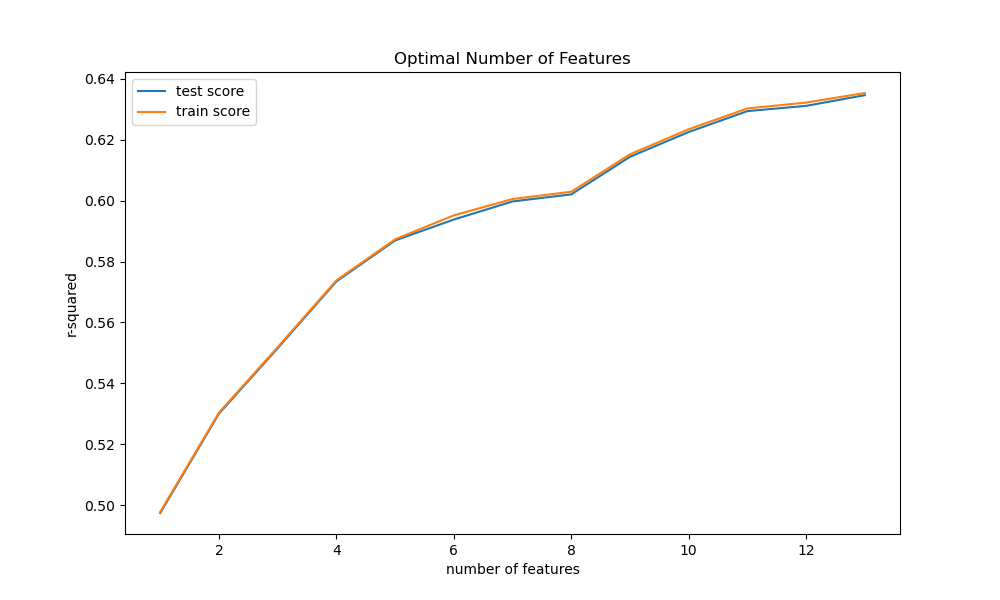

In [315]:
# plotting cv results
plt.figure(figsize=(10,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [296]:
# final model
n_features_optimal = 10

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = lm.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.8166651289396114


In [308]:
MSE(np.array(y_test), np.array(y_pred))

0    91.077926
1    72.153261
2    77.694777
3    90.845717
4   374.638705
5     0.000000
6   117.735064
dtype: float64

array([  10,    8,   29, 2846, 2929, 2873, 2598,   24,    8,    6,   11,
         48, 1813, 1951,   46,   36, 2534, 2832,   28,    6,   30, 2434,
       1526,   43,   10,    7,   38, 2004, 1189,   18, 1573, 1121,   29,
         14,    6,    4,   10,   53, 1593, 1434,   33,   31,   11,   12,
          8,    5,    8,   15,   36,   33], dtype=int64)

array([37, 50, 54, 44,  5,  0], dtype=int64)

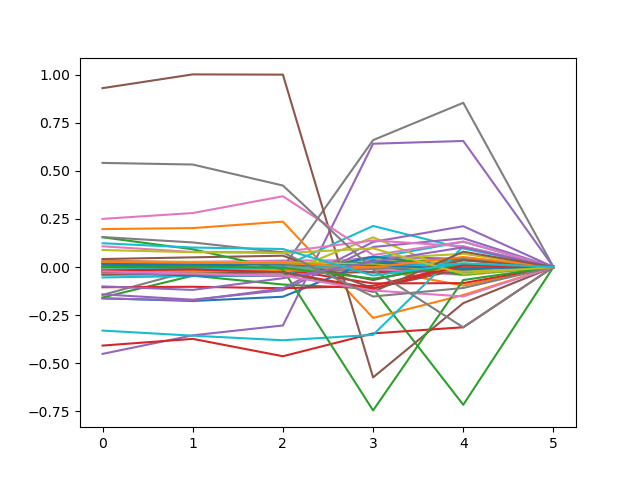

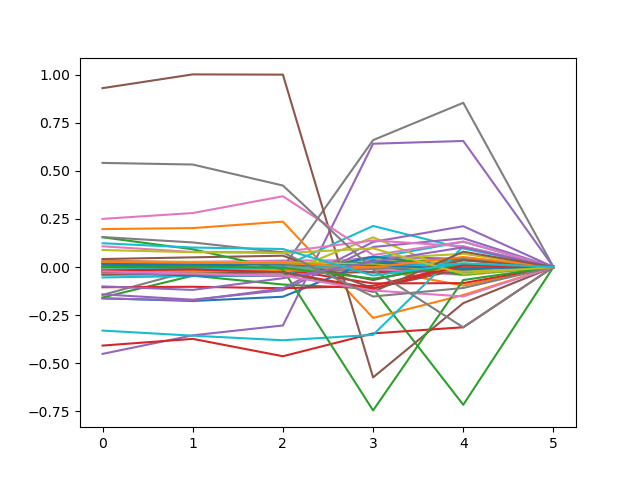

In [155]:
fig, ax = plt.subplots()

ax.plot(lr_coef_df);
fig.show()

In [242]:
X.shape, y[:,0].shape

((50296, 50), (50296,))

In [243]:
X_new = np.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])
y_new = y[:,0].reshape(-1, 1)
print(X_new.shape, y_new.shape)

(50296, 51) (50296, 1)


In [244]:
X_new = X_new / np.sqrt(np.sum(np.square(X_new), axis=0))

In [245]:
num_iters = 130 # опытным путём добиваемся минимальной разницы с предсказаниями модели за меньшее число итерации
m = X_new.shape[0]
n = X_new.shape[1]
w = np.zeros((n,1))
for i in range(num_iters):

    for k in range(n):
        # Вычисляем прогноз без k-ого фактора
        h = (X_new[:,0:k] @ w[0:k]) + (X_new[:,k+1:] @ w[k+1:])
        # Обновляем новое значение k-ого коэффициента
        w[k] =  (X_new[:,k].T @ (y_new - h))
        # Вычисляем функцию потерь
        cost = sum(((X_new @ w) - y_new) ** 2)/(len(y_new))
  
w = w.T[0]
w

array([ 3667.21733489,   -50.19973173,  -100.51288129, -6422.37943718,
         864.44377261, -3384.57030236, -7842.67955005, -1563.75359726,
       -2670.96766779,   815.44483347,   861.66310546,   181.96585054,
        4685.31011784,  9857.81972121, -3367.26049496,  -892.9055033 ,
         795.33396673, -2169.53043089, -1799.50612706, -2445.43668144,
         510.13818418, -1005.24873465, 10626.56328247,  -723.27697374,
       -2562.29787717,   943.12195932,   614.64823085,  -415.62559542,
       -1313.59359433, -2974.86658273,  -642.98200323, 14776.28886684,
       -5758.03769254,   397.30934114,   193.80040116,  -355.88655833,
        -323.26834431,  1302.16137101,  5382.17416943,  3491.97683325,
        -864.56738818, -2250.40877609, -2166.69396777,  -791.34824509,
        -776.44747658,  -724.51409567,  -625.86314452,  -152.11331864,
        1159.29307412,  2021.13900913,   -70.32029131])

In [246]:
from sklearn.linear_model import LinearRegression
 
model = LinearRegression(fit_intercept=False)
model.fit(X_new, y_new)
 
print(model.coef_)

[[ 2.30549598e+04 -4.48047633e+01 -3.41939873e+01 -1.45128410e+03
   2.22286781e+04 -2.75819678e+04 -2.75337583e+04  1.42720654e+04
  -6.40454257e+02 -3.37188333e+01 -7.16749469e+01 -6.05779644e+01
   1.50857619e+03 -4.06558660e+03  6.08235938e+03 -6.13704757e+03
   1.02969949e+04 -1.55743614e+04 -1.41318713e+04 -7.64900424e-01
  -6.51138108e+00 -7.76054609e+02  8.67258028e+03  6.40382602e+03
  -4.19901289e+03 -4.06295651e+02  9.47616217e+01  2.21930539e+03
  -8.17760513e+02 -2.86452565e+03 -1.33005345e+03  1.08880681e+04
  -6.10767655e+03  1.29524835e+03 -3.26044501e+02 -2.72206663e+02
   1.68740389e+00  2.86269308e+02  5.83889764e+03  8.76977029e+03
  -3.88324874e+03  9.59905742e+01  1.66359428e+02  4.93259594e-01
  -4.82583182e+01 -2.05770052e+02 -4.03113723e+01 -4.77414894e+01
   4.87142607e+02  6.09979140e+02  7.01156516e+02]]


In [247]:
def mse_error(y_real, y_pred):
    """_Функция вычисления среднеквадратичной ошибки_

    Args:
        y_real (_float_): _реальное значение_
        y_pred (_float_): _предсказанное значение_
    Returns:
        result (_float_): _значение MSE_
    """
    return np.square(np.subtract(y_real, y_pred)).mean()

def mae_error(y_real, y_pred):
    """_Функция вычисления абсолютной ошибки_

    Args:
        y_real (_float_): _реальное значение_
        y_pred (_float_): _предсказанное значение_
    Returns:
        result (_float_): _значение MSE_
    """
    return np.mean(np.abs(y_real - y_pred))

In [248]:
# Скопируем массив ответов
y_pred = y_new.copy()
# заполним его средним значением
y_pred.fill(y_pred.mean())
# посчитаем MSE
mse_naive = mse_error(y_new, y_pred)
print(f'MSE: {mse_error(y_new, y_pred)}')
print(f'MAE: {mae_error(y_new, y_pred)}')

MSE: 548.7771989820264
MAE: 16.142039128360107


In [249]:
# Обновим веса w для отмасштабированных данных
def lin_reg(X_new, y_new):
    a = np.dot(X_new.T, X_new)
    b = np.dot(X_new.T, y_new)
    return np.linalg.solve(a, b)

w = lin_reg(X_new, y_new).T

def lin_pred(X_new,w):
    """_Функция получит предсказания по весам линейной модели_

    Args:
        X (_array_): _матрица предикторов_
        w (_array_): _вектор весов линейной модели_

    Returns:
        _array_: _вектор прогнозов_
    """
    res = np.zeros([len(X_new),1])
    for i in range(len(X_new)):
        res[i] = (np.dot(w,X_new[i]))
    return res

y_pred = lin_pred(X_new, w)
print(f'MSE: {mse_error(y_new, y_pred)}')
print(f'MAE: {mae_error(y_new, y_pred)}')

MSE: 118.57610454464115
MAE: 8.463352836318572


In [257]:
print(f'Вектор весов, к которому сошелся метод: {w}')
print(f'На {iter_count} итерации модель остановилась с МАЕ: {mse_errors[-1]}')

Вектор весов, к которому сошелся метод: [0.03887646 0.03253989 0.03446603 0.02928042 0.0358144  0.03495933
 0.03474467 0.03578758 0.03049129 0.04071838 0.03682347 0.0387117
 0.02645178 0.03198998 0.03339824 0.03291108 0.03357017 0.03770968
 0.0348413  0.02115841 0.033437   0.02407044 0.0318338  0.03312873
 0.03440936 0.0330469  0.03369615 0.03261698 0.03433941 0.02951262
 0.02178205 0.03322288 0.03126426 0.03297094 0.03569983 0.03369034
 0.03323447 0.03612892 0.03532229 0.03719763 0.03938788 0.03505704
 0.03685001 0.03616325 0.03818234 0.03527684 0.0341085  0.0381522
 0.03837845 0.03886709 0.03964546]
На 20 итерации модель остановилась с МАЕ: 1255.4731185670685


In [258]:
# Для поиска итерации на которой достигнут минимум целевой метрики используем Pandas
model_data = pd.DataFrame({'MSE':mse_errors, 'w_value':w_values})
w_optimal = model_data.iloc[model_data['MSE'].idxmin()][1]

print(f'Минимальная целевая метрика достигнута на {model_data["MSE"].idxmin()} итерации, и составила {mse_errors[model_data["MSE"].idxmin()]} \nВеса линейной регрессии при этом составили {w_optimal}')

Минимальная целевая метрика достигнута на 18 итерации, и составила 1255.4731119261603 
Веса линейной регрессии при этом составили [0.03816434 0.03182411 0.03375811 0.0282505  0.03500502 0.0341638
 0.03394566 0.03516897 0.03009311 0.0400463  0.03609852 0.03799049
 0.02586695 0.03099834 0.03253901 0.03193423 0.03260277 0.03700111
 0.03447292 0.02080883 0.03280539 0.02396994 0.03148187 0.03254263
 0.03372504 0.03220682 0.03292846 0.03198651 0.03379011 0.02900733
 0.02142451 0.03228558 0.03068949 0.03213177 0.03492632 0.03282645
 0.03229697 0.03540792 0.03484862 0.0366677  0.03878465 0.03424947
 0.03614895 0.03520201 0.03732783 0.03433796 0.03314999 0.03732571
 0.03761205 0.03824277 0.0389136 ]


In [64]:
# ~3.8s
from sklearn.utils import resample

n_bootstaps = 10
bootstrap_X = []
bootstrap_y = []
 
for _ in range(n_bootstaps):
    sample_X, sample_y = resample(X, y)
    bootstrap_X.append(sample_X)
    bootstrap_y.append(sample_y)
    
bootstrap_X = np.array(bootstrap_X)
bootstrap_y = np.array(bootstrap_y)

bootstrap_X.shape, bootstrap_y.shape

((10, 50296, 50), (10, 50296, 6))

In [79]:
X[0]

array([  10,    8,   29, 2846, 2929, 2873, 2598,   24,    8,    6,   11,
         48, 1813, 1951,   46,   36, 2534, 2832,   28,    6,   30, 2434,
       1526,   43,   10,    7,   38, 2004, 1189,   18, 1573, 1121,   29,
         14,    6,    4,   10,   53, 1593, 1434,   33,   31,   11,   12,
          8,    5,    8,   15,   36,   33], dtype=int64)

In [97]:
# ~10m
from sklearn.linear_model import LinearRegression

model = LinearRegression()
coeffs = []

for i in np.arange(bootstrap_X.shape[0]):
    model.fit(bootstrap_X[i], bootstrap_y[i])
    coeffs.append(model.coef_)

## 4. Эмуляция реал-тайм инференса <a class="anchor" id=4></a>

[к содержанию](#0)

In [22]:
import time
#import serial
from IPython.display import clear_output


In [37]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

In [23]:
gestures_train_1 = pd.read_csv('gestures_train.csv', index_col=0)
gestures_test_1 = pd.read_csv('gestures_test.csv', index_col=0)
gestures_protocol_1 = pd.read_csv('gestures_protocol.csv')

gestures_train_2 = pd.read_csv('gestures_train_2.csv', index_col=0)
gestures_test_2 = pd.read_csv('gestures_test_2.csv', index_col=0)
gestures_protocol_2 = pd.read_csv('gestures_protocol_2.csv')

X_1 = gestures_train_1[OMG_CH].values
X_test_1 = gestures_test_1[OMG_CH].values
y_1 = gestures_train_1[GLOVE_CH].values
y_test_1 = gestures_test_1[GLOVE_CH].values
print(X_1.shape, y_1.shape, X_test_1.shape, y_test_1.shape)

X_2 = gestures_train_2[OMG_CH].values
X_test_2 = gestures_test_2[OMG_CH].values
y_2 = gestures_train_2[GLOVE_CH].values
y_test_2 = gestures_test_2[GLOVE_CH].values
X_2.shape, y_2.shape, X_test_2.shape, y_test_2.shape

(28976, 50) (28976, 6) (7244, 50) (7244, 6)


((21320, 50), (21320, 6), (5330, 50), (5330, 6))

In [24]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoLars
from sklearn.ensemble import VotingRegressor

estimators = [
    ('dt', DecisionTreeRegressor()),
    ('ll', LassoLars())
]
model_vr = MultiOutputRegressor(VotingRegressor(estimators=estimators))


model_vr.fit(X_1, y_1)

MultiOutputRegressor(estimator=VotingRegressor(estimators=[('dt',
                                                            DecisionTreeRegressor()),
                                                           ('ll',
                                                            LassoLars())]))

In [25]:
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb


model_lgbm = MultiOutputRegressor(lgb.LGBMRegressor())

model_lgbm.fit(X_1, y_1)

MultiOutputRegressor(estimator=LGBMRegressor())

In [26]:
from sklearn.metrics import mean_squared_error as mse

def MSE(y, y_pred):
    """_получение среднеквадратичной ошибки для каждого таргета_

    """
    ENC0 = mse(y[:,0], y_pred[:,0])
    ENC1 = mse(y[:,1], y_pred[:,1])
    ENC2 = mse(y[:,2], y_pred[:,2])
    ENC3 = mse(y[:,3], y_pred[:,3])
    ENC4 = mse(y[:,4], y_pred[:,4])
    ENC5 = mse(y[:,5], y_pred[:,5])
    return pd.Series([ENC0, ENC1, ENC2, ENC3, ENC4, ENC5])

def preprocessing(x):
    """_добавление изменения показаний датчиков за 1 шаг
        используется в качестве препроцессинга_
    """
    return x
    
    if prev is None:
        y = x
    else:
        y = x - prev 
    return np.append(x, y)

def inference(x):
    """_получение предсказаний модели_
        np.rint - для дотягивания float'ов до ближайших int'ов
    """
    return model_vr.predict(x.reshape(1,-1))[0]


def postprocessing(array, step=10):
    """_дискретизация предсказаний модели
        используется в качестве постпроцессинга
        сюда желательно добавить сглаживатель пиков_
    
    """
    array[array < 0] = 0
    
    return np.round(array / step, 0).astype(int) * step


def commands(x, prev):
    """_преобразование таргетов в команды
        используется в качестве финального "коэффициента подгона"_
        пока лучшего сглаживателя нет времено использую фильтр Хольта
    """
    if prev is None:
        y = x
    else:
        y = x*0.5 + prev*0.5
    return y

In [27]:
df_sim = gestures_test_1.iloc[:10000]
#df_sim = free_movements.iloc[:2000]
print(df_sim.shape)

(7244, 65)


In [30]:
TIMEOUT = 0.053
DEBUG = True

ts_list = [] 
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None



y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
    #'y_list':[],
}

while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed, y_previous)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    
  
    # [/Data logging]

    y_previous = y_postprocessed # для сглаживания 

    
    ts_list.append(ts_diff) # проверю времена выполнения
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    
    ts_old = ts_start
    i += 1 

SAMPLE SIZE: 65, OMG: 50, ACC: 6, ENCODERS: 6
BUTTON: 0, SYNC: 0, TS: 2279103
[20. 30. 50. 30. 10.  0.]


AssertionError: Calculation cycle takes more than TIMEOUT, halting...

In [60]:
#y_dct['y_commands'] = y_dct['y_commands'][1:]

for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (7244, 50)
enc_sample.shape = (7244, 6)
sample_preprocessed.shape = (7244, 50)
y_predicted.shape = (7244, 6)
y_postprocessed.shape = (7244, 6)
y_commands.shape = (7244, 6)


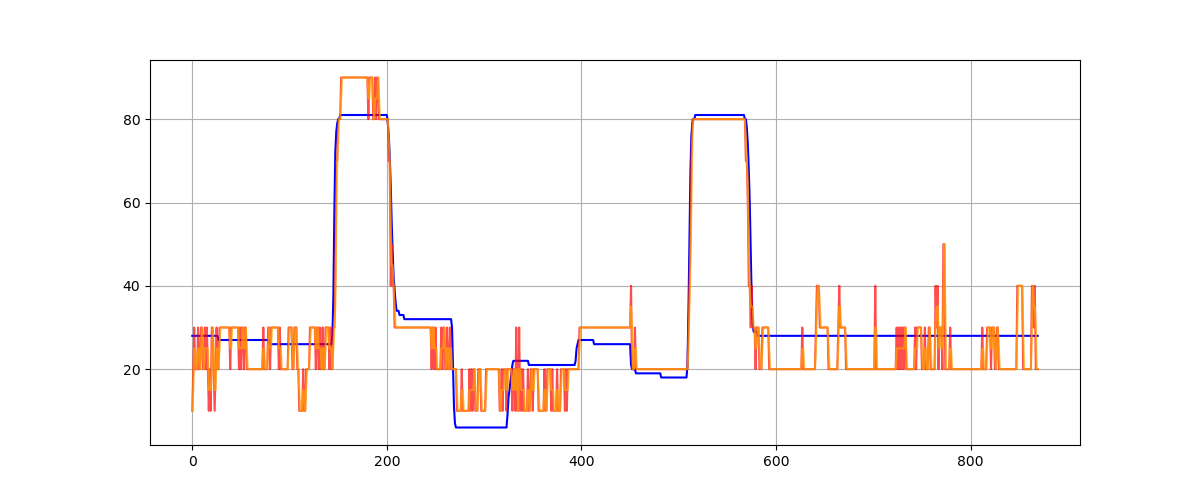

In [71]:
plt.clf()
fig = plt.figure(figsize=(12, 5))

plt.plot(y_dct['enc_sample'][:,1][:870], color='blue')
plt.plot(y_dct['y_postprocessed'][:,1][:870], color='red', alpha=0.7)
plt.plot(y_dct['y_commands'][:,1][:870], color='orange', alpha=0.7)
plt.grid()


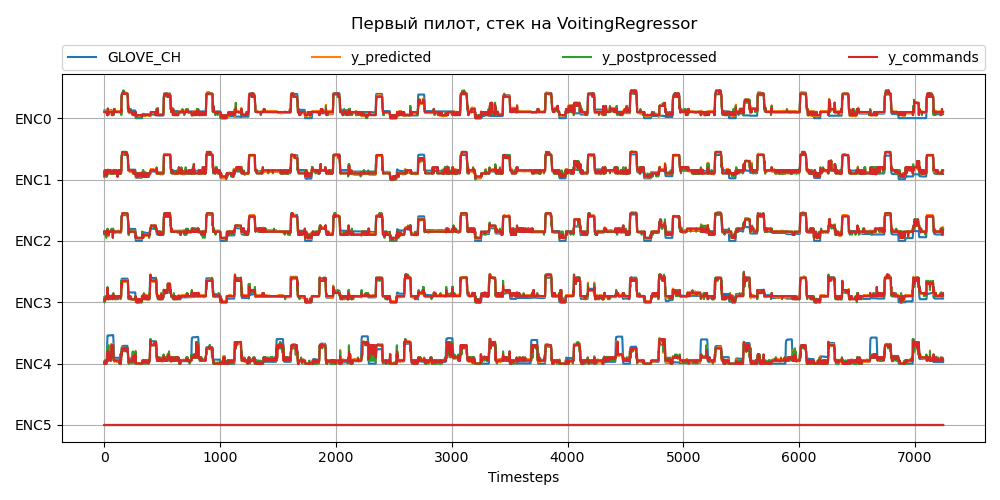

In [73]:
plt.clf()
fig = plt.figure(figsize=(10, 5))

lines = []
labels = []

plots = plt.plot(df_sim[GLOVE_CH].values - np.arange(len(GLOVE_CH)) * 200, c='C0')
lines += [plots[0]]
labels += ['GLOVE_CH']

plots = plt.plot(y_dct['y_predicted'] - np.arange(len(GLOVE_CH)) * 200, c='C1')
lines += [plots[0]]
labels += ['y_predicted']

plots = plt.plot(y_dct['y_postprocessed'] - np.arange(len(GLOVE_CH)) * 200, c='C2')
lines += [plots[0]]
labels += ['y_postprocessed']

plots = plt.plot(y_dct['y_commands'] - np.arange(len(GLOVE_CH)) * 200, c='C3')
lines += [plots[0]]
labels += ['y_commands']

plt.title('Первый пилот, стек на VoitingRegressor', y=1.1)
plt.yticks(-np.arange(len(GLOVE_CH)) * 200, GLOVE_CH)
#plt.legend(lines, labels)
plt.legend(lines, labels, bbox_to_anchor=(0, 1.01, 1, 1.01), loc='lower left',
                      ncols=5, mode="expand", borderaxespad=0.)
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

***

In [ ]:
from sklearn.metrics import mean_squared_error as mse

def MSE(y, y_pred):
    """_получение среднеквадратичной ошибки для каждого таргета_

    """
    ENC0 = mse(y[:,0], y_pred[:,0])
    ENC1 = mse(y[:,1], y_pred[:,1])
    ENC2 = mse(y[:,2], y_pred[:,2])
    ENC3 = mse(y[:,3], y_pred[:,3])
    ENC4 = mse(y[:,4], y_pred[:,4])
    ENC5 = mse(y[:,5], y_pred[:,5])
    return pd.Series([ENC0, ENC1, ENC2, ENC3, ENC4, ENC5])

def preprocessing(x, prev):
    """_добавление изменения показаний датчиков за 1 шаг
        используется в качестве препроцессинга_
    """
    if prev is None:
        y = x
    else:
        y = x - prev 
    return np.append(x, y)

def inference(x):
    """_получение предсказаний модели_
        np.rint - для дотягивания float'ов до ближайших int'ов
    """
    return model_lgbm.predict(x.reshape(1,-1))[0]


def postprocessing(array):
    """_дискретизация предсказаний модели
        используется в качестве постпроцессинга
        сюда желательно добавить сглаживатель пиков_
    
    """
    array[array < 10] = 0
    array[(array > 10) & (array <20)] = 10
    array[(array > 20) & (array <30)] = 20
    array[(array > 30) & (array <40)] = 30
    array[(array > 40) & (array <50)] = 40
    array[(array > 50) & (array <60)] = 50
    array[(array > 60) & (array <70)] = 60
    array[(array > 70) & (array <80)] = 70
    array[(array > 80) & (array <90)] = 80
    array[(array > 90) & (array <95)] = 90
    array[array > 95] = 100
    return array


def commands(x, prev):
    """_преобразование таргетов в команды
        используется в качестве финального "коэффициента подгона"_
        пока лучшего сглаживателя нет времено использую фильтр Хольта
    """
    if prev is None:
        y = x
    else:
        y = x*0.5 + prev*0.5
    return y

In [ ]:
df_sim = gestures_test.iloc[:10000]
#df_sim = free_movements.iloc[:2000]
print(df_sim.shape)

(8168, 65)


In [ ]:
TIMEOUT = 0.33
DEBUG = True

ts_list = [] 
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
omg_previous = None # эту переменную добавил для "супер умного" препроцессинга, в иделае тут всякие сглаживатели бы накрутить


y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
    #'y_list':[],
}

while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample, omg_previous)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed, y_previous)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    
  
    # [/Data logging]

    y_previous = y_postprocessed # для сглаживания 
    omg_previous = omg_sample # просто чтобы была
    
    ts_list.append(ts_diff) # проверю времена выполнения
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    
    ts_old = ts_start
    i += 1 


SAMPLE SIZE: 65, OMG: 50, ACC: 6, ENCODERS: 6
BUTTON: 1000, SYNC: 539, TS: 7856565
[ 5. 10. 10. 20. 45.  0.]


In [ ]:
#y_dct['y_commands'] = y_dct['y_commands'][1:]

for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (8168, 50)
enc_sample.shape = (8168, 6)
sample_preprocessed.shape = (8168, 100)
y_predicted.shape = (8168, 6)
y_postprocessed.shape = (8168, 6)
y_commands.shape = (8168, 6)


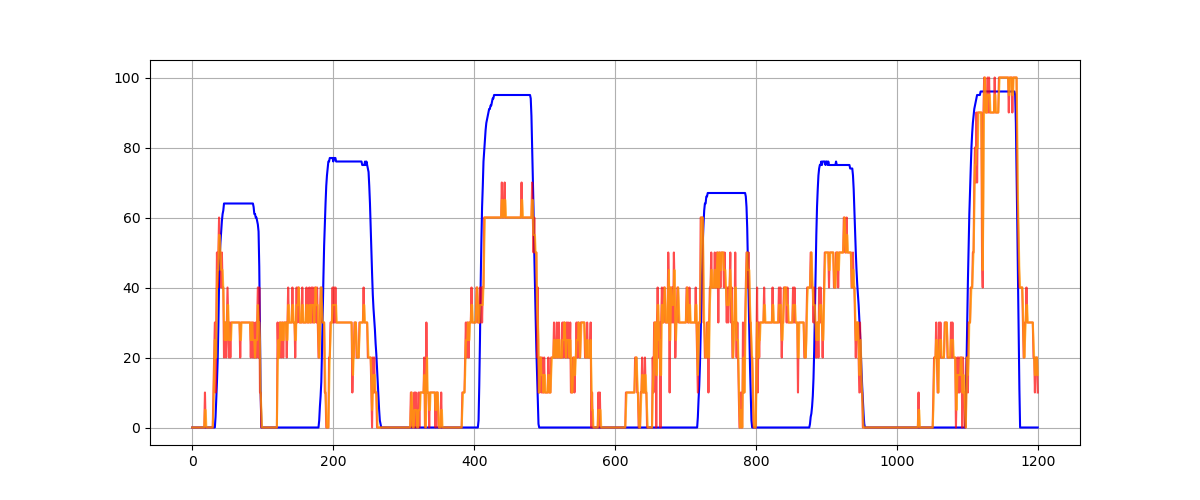

In [ ]:
plt.clf()
fig = plt.figure(figsize=(12, 5))

plt.plot(y_dct['enc_sample'][:,4][5800:7000], color='blue')
plt.plot(y_dct['y_postprocessed'][:,4][5800:7000], color='red', alpha=0.7)
plt.plot(y_dct['y_commands'][:,4][5800:7000], color='orange', alpha=0.7)
plt.grid()

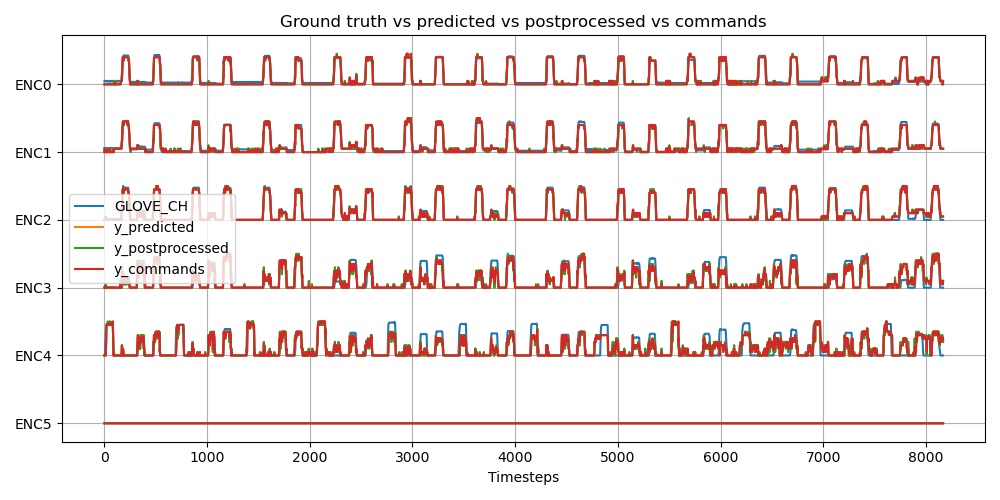

In [ ]:
plt.clf()
fig = plt.figure(figsize=(10, 5))

lines = []
labels = []

plots = plt.plot(df_sim[GLOVE_CH].values - np.arange(len(GLOVE_CH)) * 200, c='C0')
lines += [plots[0]]
labels += ['GLOVE_CH']

plots = plt.plot(y_dct['y_predicted'] - np.arange(len(GLOVE_CH)) * 200, c='C1')
lines += [plots[0]]
labels += ['y_predicted']

plots = plt.plot(y_dct['y_postprocessed'] - np.arange(len(GLOVE_CH)) * 200, c='C2')
lines += [plots[0]]
labels += ['y_postprocessed']

plots = plt.plot(y_dct['y_commands'] - np.arange(len(GLOVE_CH)) * 200, c='C3')
lines += [plots[0]]
labels += ['y_commands']

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(-np.arange(len(GLOVE_CH)) * 200, GLOVE_CH)
plt.legend(lines, labels)
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

## 5. Итоги спринта <a class="anchor" id=5></a>

[к содержанию](#0)

Я **очень** надеюсь, что правильно определил задачу первого спринта, как "общее знакомство с данными", потому, что на тестовых данных, модельки худо - бедно, но что-то показать могут, а вот со свободными жестами беда.. 

Но всё же:

* Стек из линейки и дерева вполне способен решить поставленную задачу.

* А градиентный бустинг буд-то бы созда для её решения.

* Но решения можно достигнуть при условии доработки **пред и постпроцессинга**, возможные пути:

* * Сглаживание показаний датчиков (где-то тут можно попробовать приложить авторегрессию)

* * Отсекание неинформативных датчиков (как определить какие датчики и **когда** являются "неинформативными" - отдельный вопрос)

* * Нужно больше узнать хардовую часть датчиков и процесса сьъёма показаний (хочется большей универсальности показаний, чтобы не было сильной разницы от "монтажа" и от "пилота", на данном этапе интуитивно хочется брать не сами показания а изменения в абсолютных значениях)

* * На постпроцессинге нужно срезать пики и убирать биения (сюда тоже можно приложить авторегрессию)


